# Chapter 2: Teaching Our Agent to Read 📚

In the previous chapter, we built a simple QA agent that relied solely on its pre-trained knowledge. While impressive, it had a significant limitation - it couldn't access or understand your personal documents and files. It's like having a brilliant friend who can tell you everything about world history but can't read the document right in front of them!


In this chapter, we'll fix that by teaching our agent to read and understand text files. We'll also dive deep into fascinating concepts like context windows and explore the delicate balance between context size and speed. Let's get started! 🚀

## Setup

First, let's import the `OpenAILLM` class that we coded in the previous chapter

In [1]:
from pctopus.llm.openai_llm import OpenAILLM

## Initialize the LLM
llm = OpenAILLM()

##  Teaching Our Agent to Use Context 🎓

Let's start by creating a function that helps our agent use additional context when answering questions:

In [2]:
def ask_llm_with_context(system_instruction: str, context: str, question: str, model: str = "gpt-3.5-turbo") -> str:
    """Ask a question with specific context"""

    question_with_context = f"""
        Context: {context} 
        Question: {question}
        """
    
    response = llm.ask(
        user_question=question_with_context,
        system_message=system_instruction,
        model=model
    )
    return response

Let's try it with a simple example about the Pacific Ocean:

In [3]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

context = """
The Pacific Ocean is the largest and deepest ocean on Earth. 
It covers an area of about 63 million square miles (165 million square kilometers) 
and contains more than half of the Earth's free water. The Pacific's greatest 
depth is in the Mariana Trench, which reaches down 36,070 feet (10,994 meters).
"""

questions = [
    "How deep is the Mariana Trench?",
    "What is the area covered by the Pacific Ocean?",
    "What is the temperature of the Pacific Ocean?",  # Not in context
    "What is the capital of India?" # Not in context
]


print ("Testing our context-aware QA agent:")
for question in questions:
    print(f"\nQ: {question}")
    print(f"A: {ask_llm_with_context(system_instruction, context, question)}")

Testing our context-aware QA agent:

Q: How deep is the Mariana Trench?
A: The Mariana Trench reaches a depth of 36,070 feet (10,994 meters).

Q: What is the area covered by the Pacific Ocean?
A: The area covered by the Pacific Ocean is about 63 million square miles (165 million square kilometers).

Q: What is the temperature of the Pacific Ocean?
A: I cannot find the answer in the provided context.

Q: What is the capital of India?
A: I cannot find the answer in the provided context.


Great! Our agent can now:

- ✅ Use provided context to answer questions
- ✅ Admit when it can't find information in the context
- ✅ Stick to the facts from the context

## Reading from Text Files  📄

Now that our agent can use context, let's teach it to read actual files:

In [4]:
## This function can handle most text file extensions (.txt, .md. .csv, .json, ...)
def read_text_file(file_path: str, encoding: str = 'utf-8') -> str:
    """Read content from a text file

    Args:
        file_path (str): Path to the text file
        encoding (str): File encoding (default: 'utf-8')
    
    Returns:
        str: Content of the file
        
    Raises:
        UnicodeDecodeError: If the file cannot be decoded with the specified encoding
    """
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            return file.read()
    except UnicodeDecodeError:
        # If UTF-8 fails, you could try to detect the encoding or attempt common alternatives
        common_encodings = ['latin-1', 'ascii', 'utf-16']
        for enc in common_encodings:
            try:
                with open(file_path, 'r', encoding=enc) as file:
                    return file.read()
            except UnicodeDecodeError:
                continue
        raise  # If all attempts fail, raise the original error

We'll feed the entire context from the text file to the LLM agent using the `ask_llm_with_context` function that we wrote above. 

In [6]:
def ask_llm_from_text_file(system_instruction: str, text_file_path: str, question: str, model: str = "gpt-3.5-turbo") -> str:
    """Ask a question using context from a text file as context."""
    context = read_text_file(text_file_path)
    return ask_llm_with_context(system_instruction, context, question, model)

#### Let's test it with Einstein's resume:

Albert Einstein's resume is located at `text_files/einstein_resume.txt`

In [7]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

text_file_path = "text_files/einstein_resume.txt"

questions = [
    "What's Einstein's email?",
    "How many publications does Einsetin have?",
    "What year did Einstein win his Nobel Prize in and for what?",
    "What's the name of Harry Potter's owl?", ## out of context
    "What did we talk about yesterday?" ## out of context
]

for question in questions:
    print(f"\nQ: {question}")
    print(f"A: {ask_llm_from_text_file(system_instruction, text_file_path, question)}")


Q: What's Einstein's email?
A: Einstein's email is albert.einstein@eth.zurich.ch.

Q: How many publications does Einsetin have?
A: Einstein has published over 300 scientific papers.

Q: What year did Einstein win his Nobel Prize in and for what?
A: Einstein won his Nobel Prize in Physics in 1921 for his contributions to theoretical physics and the discovery of the photoelectric effect.

Q: What's the name of Harry Potter's owl?
A: I cannot find the answer in the provided context.

Q: What did we talk about yesterday?
A: I cannot find the answer in the provided context.


#### Let's try something more ambitious. We'll feed the entire text of "The Great Gatsby" novel, which has 51,257 words, into our agent.  

This file is located at `text_files/the_great_gatsby.txt`

In [8]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

text_file_path = "text_files/the_great_gatsby.txt"

questions = [
    "How does Nick Carraway's position as both narrator and participant affect his reliability in telling Gatsby's story?",
    "What role does the green light at the end of Daisy's dock play in symbolizing Gatsby's dreams and desires?",
    "What's the name of Harry Potter's owl?", ## out of context
    "What did we talk about yesterday?" ## out of context
]

for question in questions:
    print(f"\nQ: {question}")
    print(f"A: {ask_llm_from_text_file(system_instruction, text_file_path, question)}")


Q: How does Nick Carraway's position as both narrator and participant affect his reliability in telling Gatsby's story?


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 69576 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

### Uh-oh! Seems like our agent has hit a wall! 🤖💥

If you look at the error message, it says `This model's maximum context length is 16385 tokens. However, your messages resulted in 69576 tokens. Please reduce the length of the messages.` Let's dive deeper into why this happened. 

## The Great Token Mystery: Understanding Tokens and Context Windows 🔍

### What are Tokens? 

If you remember, we breifly introduced **tokens** in Chapter 1 as the **building blocks of language that the LLM processes**. Let's revisit this concept now. 

Think of tokens as the LLM's "thought chunks" - they're the bite-sized pieces it uses to process text. Just like how we humans break down sentences into words, LLMs break down text into tokens. However, tokens don't map one-to-one with words - they can be:

- Multiple words combined ("New York", "thank you")
- Common single words ("the", "and")
- Parts of words ("ing", "ed", "pre")
- Characters (especially for uncommon words)
- Special characters and spaces

This flexible tokenization helps the model be more efficient. For example, common phrases like "thank you" or "of course" might be single tokens because they appear together so frequently. Meanwhile, rare words like "discombobulated" might be split into several tokens ("dis", "comb", "ob", "ulated").

For example, let's see how a simple sentence gets broken down into tokens:

In [9]:
import tiktoken

def show_tokenization(text: str, model: str = "gpt-3.5-turbo") -> None:
    """Show how text gets split into tokens"""
    encoding = tiktoken.encoding_for_model(model)
    tokens = encoding.encode(text)
    
    # Decode each token individually to see the splits
    token_texts = [encoding.decode_single_token_bytes(token) for token in tokens]
    
    print(f"Text: {text}")
    print(f"Token count: {len(tokens)}")
    print("Tokens:", token_texts)

# Let's try some examples
examples = [
    "Hello, world!",
    "New York City",  # Notice how city names might be tokenized
    "thank you very much",  # Common phrases
    "discombobulated",  # Uncommon word
    "OpenAI's GPT-4 😊"  # Notice how it handles special characters
]

for text in examples:
    print("\n" + "="*50)
    show_tokenization(text)


Text: Hello, world!
Token count: 4
Tokens: [b'Hello', b',', b' world', b'!']

Text: New York City
Token count: 3
Tokens: [b'New', b' York', b' City']

Text: thank you very much
Token count: 4
Tokens: [b'thank', b' you', b' very', b' much']

Text: discombobulated
Token count: 4
Tokens: [b'dis', b'comb', b'ob', b'ulated']

Text: OpenAI's GPT-4 😊
Token count: 9
Tokens: [b'Open', b'AI', b"'s", b' G', b'PT', b'-', b'4', b' \xf0\x9f\x98', b'\x8a']


### Different Models, Different Tokenizers 🔄

Each LLM family typically comes with its own tokenizer - the tool that breaks text into tokens. This means the same text might be split very differently depending on which model you're using:


#### GPT-2 Tokenizer ("gpt2")
- Basic tokenization approach
- Limited emoji support
- Vocabulary size: ~50k tokens
- Primarily focused on English text

#### GPT-3.5/GPT-4 Tokenizer ("cl100k_base")
- Optimized for modern internet text
- Strong handling of code and technical content
- Good emoji support
- Vocabulary size: ~100k tokens
- Improved efficiency in token usage

#### GPT-4 Optimized Tokenizer ("o200k_base")
- Significantly larger vocabulary (~200k tokens)
- Enhanced multilingual support
- More efficient tokenization for non-English words
- Particularly improved performance for:
  - Russian
  - Korean
  - Vietnamese
  - Chinese
  - Japanese
  - Turkish

These differences matter because:

1. The same text will use different numbers of tokens in different models
2. Cost calculations vary (since you pay per token)
3. Context window limits affect different amounts of text
4. Some models handle certain content types better

Let's see these differences in action:

In [10]:
import tiktoken
import pandas as pd
from typing import Dict

def compare_tokenizers(text: str) -> Dict[str, int]:
    """Compare how different tokenizers process the same text."""
    # Define models with different tokenizers
    models = {
        "GPT-2": "gpt2",
        "GPT-3.5": "gpt-3.5-turbo",  # Uses cl100k_base
    }
    
    # Count tokens for each model
    results = {}
    for name, model in models.items():
        encoding = tiktoken.encoding_for_model(model)
        tokens = encoding.encode(text)
        results[name] = len(tokens)
        
        # Show the actual tokens for analysis
        token_texts = [encoding.decode_single_token_bytes(token) for token in tokens]
        print(f"\n{name} tokenization of '{text}':")
        print(f"Token count: {len(tokens)}")
        print("Tokens:", token_texts)
        
    return results

# Test cases demonstrating key differences
test_cases = {
    "Common Phrase": "thank you",
    "Non-English": "こんにちは",  # Japanese
}

print("🔍 Comparing different tokenizers:")
print("=" * 50)

# Run comparison for each test case
for case_name, text in test_cases.items():
    print(f"\n📝 Test case: {case_name}")
    results = compare_tokenizers(text)
    
    # Show token count differences
    df = pd.DataFrame([results]).T
    df.columns = ['Token Count']
    print("\nToken count comparison:")
    print(df)
    print("=" * 50)

🔍 Comparing different tokenizers:

📝 Test case: Common Phrase

GPT-2 tokenization of 'thank you':
Token count: 2
Tokens: [b'thank', b' you']

GPT-3.5 tokenization of 'thank you':
Token count: 2
Tokens: [b'thank', b' you']

Token count comparison:
         Token Count
GPT-2              2
GPT-3.5            2

📝 Test case: Non-English

GPT-2 tokenization of 'こんにちは':
Token count: 6
Tokens: [b'\xe3\x81\x93', b'\xe3\x82\x93', b'\xe3\x81\xab', b'\xe3\x81', b'\xa1', b'\xe3\x81\xaf']

GPT-3.5 tokenization of 'こんにちは':
Token count: 1
Tokens: [b'\xe3\x81\x93\xe3\x82\x93\xe3\x81\xab\xe3\x81\xa1\xe3\x81\xaf']

Token count comparison:
         Token Count
GPT-2              6
GPT-3.5            1


### Context Windows: The LLM's Working Memory 🪟

The context window is like the LLM's working memory - it's the maximum amount of tokens that the model can "think about" at once. This includes:

- The system message (instructions we give)
- The context (like our document text)
- The user's question
- The LLM's response

Different models have different context window sizes:

| Model | Context Window | 
|:--|:--|
| GPT-3.5-Turbo | 16,385 tokens |
| GPT-4o-mini | 128,000 tokens | 
| GPT-4o | 128,000 tokens |

## Understanding Why The Great Gatsby Example Failed 🔍

Remember how our attempt to analyze The Great Gatsby failed with an error about exceeding the context window? Now that we understand tokens and context windows, let's break down exactly what happened.

Let's calculate the tokens we were trying to use:

In [11]:
def count_tokens(text: str, model: str = "gpt-3.5-turbo") -> int:
    """Count tokens for a given text using specified model's tokenizer"""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

gatsby_text = read_text_file("text_files/the_great_gatsby.txt")
gatsby_tokens = count_tokens(gatsby_text)

print(f"Tokens in the Great Gatsby text: {gatsby_tokens:,} tokens")

Tokens in the Great Gatsby text: 69,499 tokens


Remember, **GPT-3.5-turbo** has a context window of **16,385 tokens**. Just The Great Gatsby alone uses about **69,499 tokens!** That's not even including the system instructions and the user question. That's why we got the error message. It's like trying to fit an entire novel into a small notepad.

### Let's Fix It: Using GPT-4o-mini 🛠️

GPT-4-mini has a much larger context window of 128,000 tokens. Let's modify our code to use it instead:

In [14]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

text_file_path = "text_files/the_great_gatsby.txt"

questions = [
    "How does Nick Carraway's position as both narrator and participant affect his reliability in telling Gatsby's story?",
    "What role does the green light at the end of Daisy's dock play in symbolizing Gatsby's dreams and desires?",
    "What's the name of Harry Potter's owl?", ## out of context
    "What did we talk about yesterday?" ## out of context
]

for question in questions:
    print(f"\nQ: {question}")
    print(f"A: {ask_llm_from_text_file(system_instruction, text_file_path, question, model='gpt-4o-mini')}")


Q: How does Nick Carraway's position as both narrator and participant affect his reliability in telling Gatsby's story?
A: Nick Carraway's position as both narrator and participant in "The Great Gatsby" significantly impacts his reliability in conveying Gatsby's story. As a first-person narrator, Nick offers a personal perspective that creates intimacy and depth in the narrative. However, his involvement in the events he recounts can lead to biases and subjective interpretations.

1. **Subjective Experience**: Nick's personal experiences and feelings influence how he perceives Gatsby and the other characters. For instance, his admiration for Gatsby leads him to present Gatsby in a more sympathetic light, often glossing over his dubious actions and associations. This admiration might skew Nick's portrayal, prompting readers to question the objectivity of his narrative.

2. **Limited Knowledge**: While Nick is a participant in the story, he does not know everything about Gatsby or the o

## The Cost of Large Contexts: Measuring Latency 📊

You might have noticed that running the previous code might have taken some time before you got a response back. That's because typically, **the more context we feed into an LLM, the longer it takes to process.** 

Let's measure the response time of an LLM for different text length to prove this:

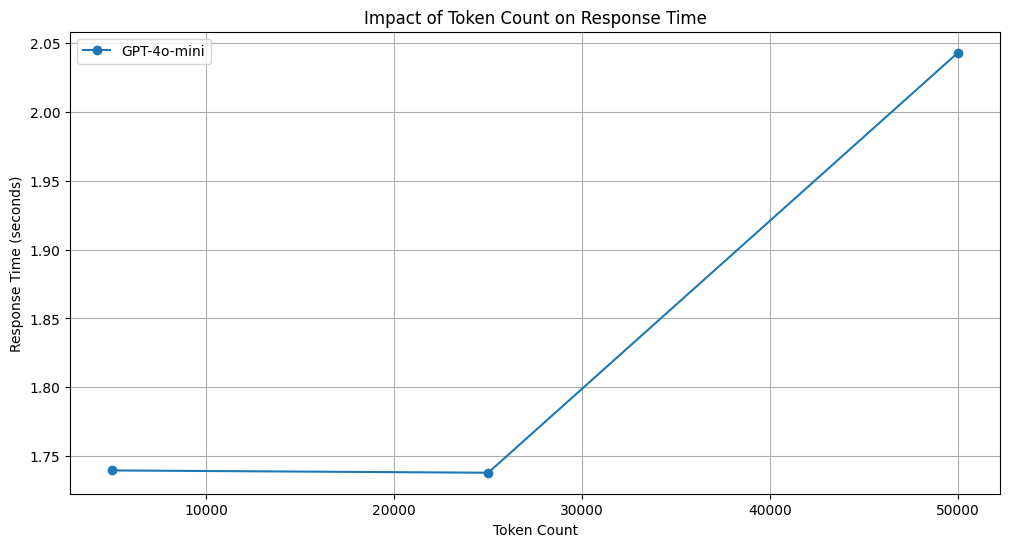

In [28]:
import time
import tiktoken
import matplotlib.pyplot as plt

def generate_text_with_token_count(target_token_count: int) -> str:
    """Generate text with approximately the specified number of tokens"""
    # Initialize tokenizer
    tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")
    
    # Base text that we'll repeat
    base_text = "This is a sample text for testing language model response times. "
    base_tokens = len(tokenizer.encode(base_text))
    
    # Calculate how many repetitions we need
    repetitions = target_token_count // base_tokens
    
    # Generate the text
    context = base_text * repetitions
    
    # Fine-tune to get closer to target token count
    current_tokens = len(tokenizer.encode(context))
    while current_tokens < target_token_count:
        context += "Additional text. "
        current_tokens = len(tokenizer.encode(context))
    
    return context

def measure_response_time(token_count: int, model: str) -> float:
    """Measure response time for different token counts"""
    # Generate context with specified token count
    context = generate_text_with_token_count(token_count)
    
    start_time = time.time()
    response = ask_llm_with_context(
        system_instruction="Summarize the text",
        context=context,
        question="",
        model=model
    )
    end_time = time.time()
    
    return end_time - start_time

# Test different token counts
token_counts = [50000, 25000, 5000]
response_times_4 = []

for count in token_counts:
    time_4 = measure_response_time(count, "gpt-4o-mini")
    response_times_4.append(time_4)

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(token_counts, response_times_4, marker='o', label='GPT-4o-mini')
plt.xlabel('Token Count')
plt.ylabel('Response Time (seconds)')
plt.title('Impact of Token Count on Response Time')
plt.legend()
plt.grid(True)
plt.show()

As you can see from the graph, there's a clear correlation between context size and response time. The larger the context, the longer we have to wait for an answer.

## Problems with Our Current Approach 🤔

Our current method of feeding entire documents into the context window has several significant drawbacks:

Context Window Limits

Large documents exceed model context windows
Multiple documents compound the problem
Important information might get cut off


Cost Implications

Paying for tokens we might not need
Each request includes full document cost
Inefficient for repeated queries


Latency Issues

Larger contexts = slower responses
Poor user experience with long wait times
Resource intensive


Scalability Problems

Cannot handle growing document collections
Limited by single context window
No way to process large document libraries